In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from syd import make_viewer

from src.iaf.experiments import get_experiment

base_dp_ratio = 1.1
distal_dp_ratio = 1.05
no_distal = False
config = "hofer_explore"
num_simulations = 3
sim, cfg = get_experiment(
    config,
    base_dp_ratio=base_dp_ratio,
    distal_dp_ratio=distal_dp_ratio,
    no_distal=no_distal,
    num_simulations=num_simulations,
    edge_probability=0.75,
)

In [ ]:
results = sim.run(duration=2400, initialize=True)

 31%|███       | 741/2400 [01:05<02:25, 11.39it/s]

In [4]:
def make_psth(spike_times, duration, dt):
    psth = np.zeros((duration * int(1/dt)))
    psth[spike_times] = 1
    psth = np.sum(np.reshape(psth, (duration, -1)), axis=1)
    return psth

In [5]:
duration = results["weights"][0]["basal"].shape[0]
dt = cfg.dt

psths = np.stack([make_psth(st, duration, dt) for st in results["spike_times"]], axis=0)
basal_weights = np.stack([w["basal"][-1] for w in results["weights"]], axis=0)
simple_weights = np.stack([w["apical-simple"][-1] for w in results["weights"]], axis=0)
complex_weights = np.stack([w["apical-complex"][-1] for w in results["weights"]], axis=0)

basal_weights = basal_weights / cfg.synapses["basal"].max_weight / cfg.synapses["basal"].num_synapses * 4
simple_weights = simple_weights / cfg.synapses["apical-simple"].max_weight / cfg.synapses["apical-simple"].num_synapses * 20
complex_weights = complex_weights / cfg.synapses["apical-complex"].max_weight / cfg.synapses["apical-complex"].num_synapses * 20

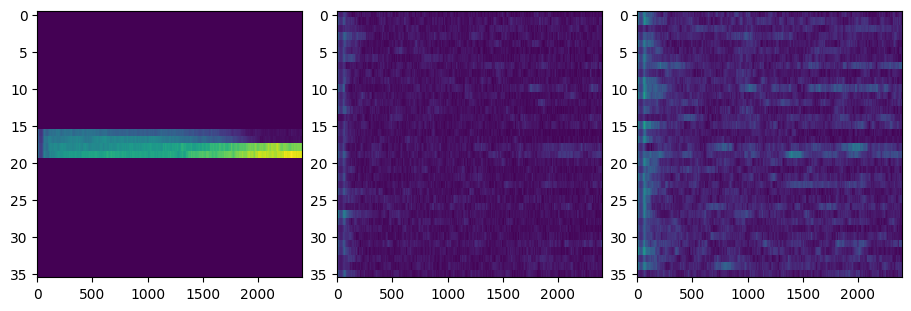

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout="constrained")
ax[0].imshow(results["weights"][0]["basal"].T, aspect="auto", interpolation="none")
ax[1].imshow(results["weights"][0]["apical-simple"].T, aspect="auto", interpolation="none")
ax[2].imshow(results["weights"][0]["apical-complex"].T, aspect="auto", interpolation="none")
plt.show()

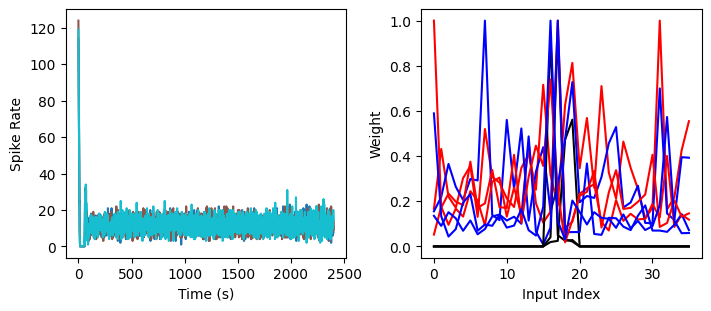

In [ ]:
cmap = plt.get_cmap("tab10")
colors = cmap(np.linspace(0, 1, psths.shape[0]))

fig, ax = plt.subplots(1, 2, figsize=(7, 3), layout="constrained")
for ineuron in range(psths.shape[0]):
    ax[0].plot(psths[ineuron], color=colors[ineuron])
    ax[1].plot(basal_weights[ineuron], color="k")
    ax[1].plot(simple_weights[ineuron] / np.max(simple_weights[ineuron]), color="r")
    ax[1].plot(complex_weights[ineuron] / np.max(complex_weights[ineuron]), color="b")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Spike Rate")
ax[1].set_xlabel("Input Index")
ax[1].set_ylabel("Weight")
plt.show()

In [8]:
from src.iaf.plotting import create_gabor, stitch_gabor_grid

def weights_to_gabor(weights, orientations, spacing=2, **params):
    weights = weights.T.reshape(9, 4)
    gabors = [[None for _ in range(weights.shape[1])] for _ in range(weights.shape[0])]
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            gabor = weights[i, j] * create_gabor(orientation=orientations[j], **params)
            gabors[i][j] = gabor
        gabors[i] = np.sum(np.stack(gabors[i]), axis=0)
    gwidth = gabors[0].shape[0]
    gabors = np.stack(gabors).reshape(3, 3, gwidth, gwidth)
    return stitch_gabor_grid(gabors, spacing=spacing)

In [ ]:
gabor = sim.source_populations["excitatory"]

def plot(state):
    ineuron = state["neuron"]
    spacing = state["spacing"]
    vmax = state["vmax"]

    basal_gabor = weights_to_gabor(basal_weights[ineuron], gabor.orientations, spacing=spacing)
    simple_gabor = weights_to_gabor(simple_weights[ineuron], gabor.orientations, spacing=spacing)
    complex_gabor = weights_to_gabor(complex_weights[ineuron], gabor.orientations, spacing=spacing)

    fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout="constrained")
    ax[0].imshow(basal_gabor, vmin=-vmax, vmax=vmax, cmap="bwr")
    ax[0].set_title(f"{np.max(basal_gabor)}")
    ax[1].imshow(simple_gabor, vmin=-vmax, vmax=vmax, cmap="bwr")
    ax[1].set_title(f"{np.max(simple_gabor)}")
    ax[2].imshow(complex_gabor, vmin=-vmax, vmax=vmax, cmap="bwr")
    ax[2].set_title(f"{np.max(complex_gabor)}")
    return fig

viewer = make_viewer(plot)
viewer.add_integer("neuron", value=0, min_value=0, max_value=psths.shape[0] - 1)
viewer.add_integer("spacing", value=3, min_value=0, max_value=10)
viewer.add_float("vmax", value=0.5, min_value=0.0, max_value=1.0)
viewer = viewer.deploy(env="notebook")

In [9]:
gabor = sim.source_populations["excitatory"]

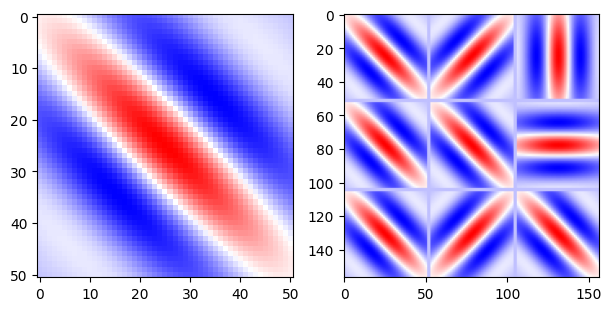

In [294]:
from src.iaf.plotting import create_gabor, create_gabor_grid

params = dict(
    width=0.6,
    envelope=0.4,
    gamma=1.5,
    halfsize=25,
    phase=0,
)
stim = gabor.generate_stimulus(edge_probability=1.1)
stimori = gabor.orientations[stim]
single = create_gabor(orientation=stimori[1, 1], **params)
# ssss = get_gabor(sigma=25, theta=stimori[1, 1], Lambda=28, psi=0, gamma=0.5)
grid = create_gabor_grid(stimori, spacing=2, gabor_params=params)
fig, ax = plt.subplots(1, 2, figsize=(6, 3), layout="constrained")
ax[0].imshow(single, aspect="auto", cmap="bwr")
ax[1].imshow(grid, aspect="auto", cmap="bwr")
plt.show()

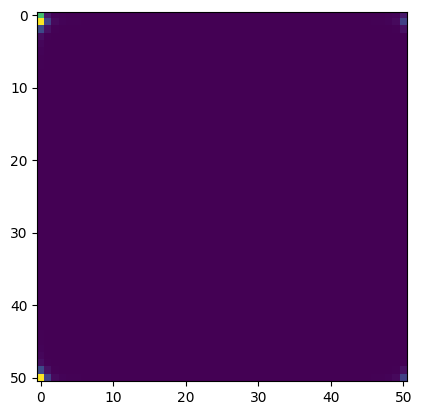

In [196]:
fft = np.fft.fft2(single)
plt.imshow(np.abs(fft))
plt.show()